In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
!unzip -q /kaggle/input/lsdc-gen-yolo-data-nf/data_fold0.zip

In [3]:
IMG_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"
FOLD = 0
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 64
EPOCHS = 40

SAMPLE = None
CONDITIONS = ['Left Neural Foraminal Narrowing', 'Right Neural Foraminal Narrowing']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'

In [4]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [5]:
fold_df = pd.read_csv('/kaggle/input/lsdc-fold-split/5folds.csv')

In [6]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found '+ lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)
#     raise ValueError('Condition not found '+ lev)

In [7]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [8]:
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)
#         break
#     break

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [9]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [10]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]

In [11]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [12]:
ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [13]:
img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    lbl = f"{get_accronym(row['condition'])}_{row['level']}"
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color =  (0, 255, 0)
    elif row['label'] == 'Moderate':
        color = (255,255,0) 
    elif row['label'] == 'Severe':
        color = (255,0,0)
        
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, lbl, (x1,y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

tmp_df

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
43833,3870889542,Spinal Canal Stenosis,L1/L2,Normal/Mild,3,1025648500,8,301.762832,167.872566,Sagittal T2/STIR
43834,3870889542,Spinal Canal Stenosis,L2/L3,Normal/Mild,3,1025648500,8,285.714286,221.028571,Sagittal T2/STIR
43835,3870889542,Spinal Canal Stenosis,L3/L4,Normal/Mild,3,1025648500,8,274.909091,277.090909,Sagittal T2/STIR
43836,3870889542,Spinal Canal Stenosis,L4/L5,Normal/Mild,3,1025648500,8,271.858407,326.456637,Sagittal T2/STIR
43837,3870889542,Spinal Canal Stenosis,L5/S1,Normal/Mild,3,1025648500,8,277.295575,369.953982,Sagittal T2/STIR


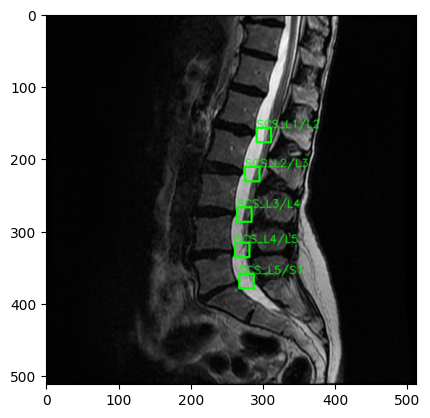

In [14]:
plt.imshow(img)
plt.show()

In [15]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

In [16]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [17]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1


In [18]:
id2label

{0: 'left_neural_foraminal_narrowing_l1_l2_normal/mild',
 1: 'left_neural_foraminal_narrowing_l1_l2_moderate',
 2: 'left_neural_foraminal_narrowing_l1_l2_severe',
 3: 'left_neural_foraminal_narrowing_l2_l3_normal/mild',
 4: 'left_neural_foraminal_narrowing_l2_l3_moderate',
 5: 'left_neural_foraminal_narrowing_l2_l3_severe',
 6: 'left_neural_foraminal_narrowing_l3_l4_normal/mild',
 7: 'left_neural_foraminal_narrowing_l3_l4_moderate',
 8: 'left_neural_foraminal_narrowing_l3_l4_severe',
 9: 'left_neural_foraminal_narrowing_l4_l5_normal/mild',
 10: 'left_neural_foraminal_narrowing_l4_l5_moderate',
 11: 'left_neural_foraminal_narrowing_l4_l5_severe',
 12: 'left_neural_foraminal_narrowing_l5_s1_normal/mild',
 13: 'left_neural_foraminal_narrowing_l5_s1_moderate',
 14: 'left_neural_foraminal_narrowing_l5_s1_severe',
 15: 'right_neural_foraminal_narrowing_l1_l2_normal/mild',
 16: 'right_neural_foraminal_narrowing_l1_l2_moderate',
 17: 'right_neural_foraminal_narrowing_l1_l2_severe',
 18: 'right

In [19]:
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

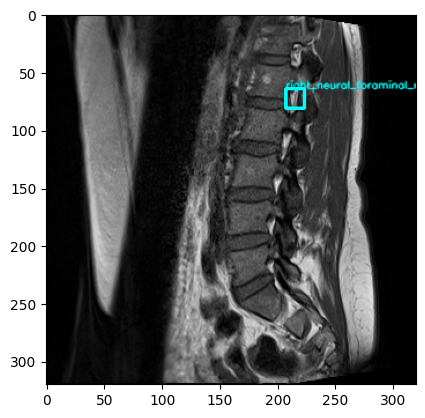

In [20]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [24]:
# Install the ultralytics package from GitHub
!pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-xo3sog9q
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-xo3sog9q
  Resolved https://github.com/ultralytics/ultralytics.git to commit e56f9140fbe5db69805a81094739163e23cbc5b7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.5-py3-none-any.whl size=882820 sha256=56b1e7bce0032ba97025a689ba3225e1e666b8b242a3c000339fe032bfeccdca
  Stored in directory: /tmp/pip-ephem-wheel-cache-7sr8ycpf/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f842eeb37142fdccb5b
Successfully built ultralytics


In [25]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: left_neural_foraminal_narrowing_l1_l2_normal/mild
1: left_neural_foraminal_narrowing_l1_l2_moderate
2: left_neural_foraminal_narrowing_l1_l2_severe
3: left_neural_foraminal_narrowing_l2_l3_normal/mild
4: left_neural_foraminal_narrowing_l2_l3_moderate
5: left_neural_foraminal_narrowing_l2_l3_severe
6: left_neural_foraminal_narrowing_l3_l4_normal/mild
7: left_neural_foraminal_narrowing_l3_l4_moderate
8: left_neural_foraminal_narrowing_l3_l4_severe
9: left_neural_foraminal_narrowing_l4_l5_normal/mild
10: left_neural_foraminal_narrowing_l4_l5_moderate
11: left_neural_foraminal_narrowing_l4_l5_severe
12: left_neural_foraminal_narrowing_l5_s1_normal/mild
13: left_neural_foraminal_narrowing_l5_s1_moderate
14: left_neural_foraminal_narrowing_l5_s1_severe
15: right_neural_foraminal_narrowing_l1_l2_normal/mild
16: right_neural_foraminal_narrowing_l1_l2_moderate
17: right_neural_foraminal_narrowing_l1_l2_severe
18: right_neural_foraminal_narrowing_l2_l3_normal/mild
19: right_neural_foraminal_n

In [26]:
%%writefile yolo_scs.yaml
path: /kaggle/working/data_fold0 # dataset root dir
train: images/train  
val: images/val 
test: images/val 

# Classes
names:
    0: left_neural_foraminal_narrowing_l1_l2_normal/mild
    1: left_neural_foraminal_narrowing_l1_l2_moderate
    2: left_neural_foraminal_narrowing_l1_l2_severe
    3: left_neural_foraminal_narrowing_l2_l3_normal/mild
    4: left_neural_foraminal_narrowing_l2_l3_moderate
    5: left_neural_foraminal_narrowing_l2_l3_severe
    6: left_neural_foraminal_narrowing_l3_l4_normal/mild
    7: left_neural_foraminal_narrowing_l3_l4_moderate
    8: left_neural_foraminal_narrowing_l3_l4_severe
    9: left_neural_foraminal_narrowing_l4_l5_normal/mild
    10: left_neural_foraminal_narrowing_l4_l5_moderate
    11: left_neural_foraminal_narrowing_l4_l5_severe
    12: left_neural_foraminal_narrowing_l5_s1_normal/mild
    13: left_neural_foraminal_narrowing_l5_s1_moderate
    14: left_neural_foraminal_narrowing_l5_s1_severe
    15: right_neural_foraminal_narrowing_l1_l2_normal/mild
    16: right_neural_foraminal_narrowing_l1_l2_moderate
    17: right_neural_foraminal_narrowing_l1_l2_severe
    18: right_neural_foraminal_narrowing_l2_l3_normal/mild
    19: right_neural_foraminal_narrowing_l2_l3_moderate
    20: right_neural_foraminal_narrowing_l2_l3_severe
    21: right_neural_foraminal_narrowing_l3_l4_normal/mild
    22: right_neural_foraminal_narrowing_l3_l4_moderate
    23: right_neural_foraminal_narrowing_l3_l4_severe
    24: right_neural_foraminal_narrowing_l4_l5_normal/mild
    25: right_neural_foraminal_narrowing_l4_l5_moderate
    26: right_neural_foraminal_narrowing_l4_l5_severe
    27: right_neural_foraminal_narrowing_l5_s1_normal/mild
    28: right_neural_foraminal_narrowing_l5_s1_moderate
    29: right_neural_foraminal_narrowing_l5_s1_severe

Overwriting yolo_scs.yaml


In [27]:
# pip install wandb

In [28]:
import wandb
from wandb.integration.ultralytics import add_wandb_callback

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandbkey")
wandb.login(key=secret_value_0)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [29]:
# Initialize W&B run
wandb.init(
    project="lsdc_yolov8",
#     name=f"Demo_fold0",
#     tags=["baseline", "search-lr", ],
    group=";".join(CONDITIONS),
#     config={
#         "lr": LR,
#         "model-name":"xtremedistill-trim",
#         "dataset": [
#             "raw_compettion",
#             "MPWare",
#             "Nicholas"
#         ]
#     }
)


wandb: Currently logged in as: harsha-vardhanreddy2020 (neha_lm). Use `wandb login --relogin` to force relogin


In [30]:
from ultralytics import YOLO


# Initialize YOLO Model
model = YOLO("yolov8s.pt")

# Add W&B callback for Ultralytics
add_wandb_callback(model, enable_model_checkpointing=True)

# Train/fine-tune your model
# At the end of each epoch, predictions on validation batches are logged
# to a W&B table with insightful and interactive overlays for
# computer vision tasks
model.train(project="lsdc_yolov8", data="yolo_scs.yaml", 
            epochs=EPOCHS, imgsz=OD_INPUT_SIZE, batch=BATCH_SIZE)

# Finish the W&B run
wandb.finish()

100%|██████████| 21.5M/21.5M [00:00<00:00, 256MB/s]


Ultralytics 8.3.5 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=yolo_scs.yaml, epochs=40, time=None, patience=100, batch=64, imgsz=384, save=True, save_period=-1, cache=False, device=None, workers=8, project=lsdc_yolov8, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 24.8MB/s]
2024-10-06 14:13:05,938	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-10-06 14:13:06,484	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=30

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 95.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data_fold0/labels/train... 6621 images, 15 backgrounds, 0 corrupt: 100%|██████████| 6621/6621 [00:05<00:00, 1130.94it/s]


train: New cache created: /kaggle/working/data_fold0/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold0/labels/val... 1661 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1661/1661 [00:01<00:00, 980.66it/s] 


val: New cache created: /kaggle/working/data_fold0/labels/val.cache
Plotting labels to lsdc_yolov8/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000294, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0005), 69 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to lsdc_yolov8/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      6.98G      2.663      5.319      1.225        103        384: 100%|██████████| 104/104 [00:44<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]

                   all       1661       3950       0.03       0.21     0.0366     0.0166
Ultralytics 8.3.5 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv8s summary (fused): 168 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      6.95G      1.892       2.98     0.9604        112        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.413      0.216      0.103     0.0436


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      6.97G      1.812      2.429     0.9506        101        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]

                   all       1661       3950      0.474      0.264      0.141      0.061


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      6.93G      1.747      2.174     0.9451        104        384: 100%|██████████| 104/104 [00:44<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]

                   all       1661       3950      0.355      0.364      0.174     0.0826


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      7.44G       1.71      2.036     0.9362        112        384: 100%|██████████| 104/104 [00:44<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]

                   all       1661       3950       0.33      0.403      0.201     0.0936


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      6.94G      1.657      1.949     0.9289         92        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]

                   all       1661       3950      0.356      0.429       0.21     0.0894


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      6.96G      1.641      1.904     0.9246        143        384: 100%|██████████| 104/104 [00:44<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]

                   all       1661       3950      0.374      0.467      0.232      0.115


Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      6.96G      1.623      1.855     0.9202         98        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.385      0.464      0.236       0.12


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      6.93G      1.588      1.821      0.912         86        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]

                   all       1661       3950      0.301       0.47      0.265      0.134


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      7.38G      1.588      1.786     0.9176         99        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]

                   all       1661       3950      0.318       0.49      0.293      0.149


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      6.96G      1.581      1.743     0.9134         73        384: 100%|██████████| 104/104 [00:43<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.305      0.489      0.325      0.161


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      6.92G      1.583        1.7     0.9141        109        384: 100%|██████████| 104/104 [00:44<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]

                   all       1661       3950       0.39      0.448      0.361      0.186


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      6.92G      1.569      1.582     0.9116        105        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.366      0.516       0.39      0.189


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      6.96G      1.555      1.541     0.9087         92        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]

                   all       1661       3950      0.471      0.517      0.428      0.213


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      6.93G      1.556      1.493     0.9112        117        384: 100%|██████████| 104/104 [00:44<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]

                   all       1661       3950      0.525      0.544      0.468      0.238


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      6.95G      1.549      1.475     0.9097        116        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.462      0.551      0.464      0.216


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      6.95G      1.546      1.445     0.9092         83        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.497      0.557      0.457      0.205


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      6.97G      1.526      1.426     0.9022        103        384: 100%|██████████| 104/104 [00:44<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.517      0.543      0.468      0.238


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      6.93G      1.528      1.418     0.9086        102        384: 100%|██████████| 104/104 [00:44<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]

                   all       1661       3950      0.445      0.527       0.47      0.246


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      6.96G      1.517      1.391     0.9025        119        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]

                   all       1661       3950      0.479      0.539      0.477      0.244


Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      6.98G      1.506      1.381     0.9007         99        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]

                   all       1661       3950      0.455       0.56      0.475      0.237


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      6.96G      1.512      1.383     0.8997        103        384: 100%|██████████| 104/104 [00:44<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.491      0.589       0.48      0.249


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      6.91G      1.499      1.366     0.9002         83        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.563      0.535      0.481      0.231


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      6.92G        1.5      1.363     0.9017         98        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]

                   all       1661       3950      0.477      0.568      0.491       0.25


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      6.97G      1.488      1.351     0.9001         76        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]

                   all       1661       3950      0.508      0.558      0.478      0.251


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      6.94G      1.485      1.336      0.898        109        384: 100%|██████████| 104/104 [00:43<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]

                   all       1661       3950      0.521      0.548       0.49      0.248


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      6.91G      1.482      1.314     0.8989         94        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950       0.51      0.566      0.486      0.247


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      6.95G      1.484      1.312     0.8966        122        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]

                   all       1661       3950       0.47      0.559      0.493      0.258


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      6.92G      1.473       1.32     0.8978         84        384: 100%|██████████| 104/104 [00:43<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]

                   all       1661       3950       0.49       0.55      0.491      0.253


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      6.94G      1.469      1.314     0.8934         69        384: 100%|██████████| 104/104 [00:44<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]

                   all       1661       3950      0.475      0.558      0.494      0.256


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40       6.9G      1.457      1.235     0.9216         73        384: 100%|██████████| 104/104 [00:44<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.483      0.574      0.486      0.249


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      6.91G      1.433      1.232     0.9191         90        384: 100%|██████████| 104/104 [00:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]

                   all       1661       3950      0.483      0.552      0.488      0.256


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40       6.9G      1.428      1.213      0.916         70        384: 100%|██████████| 104/104 [00:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.68it/s]

                   all       1661       3950       0.48      0.547      0.494      0.257


Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40       6.9G      1.412      1.194     0.9152         63        384: 100%|██████████| 104/104 [00:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.523      0.564      0.482      0.256


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      6.89G      1.409        1.2     0.9128         68        384: 100%|██████████| 104/104 [00:43<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.438       0.58      0.484      0.255


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40       6.9G      1.399      1.197     0.9105         66        384: 100%|██████████| 104/104 [00:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]

                   all       1661       3950      0.467      0.584      0.484      0.255


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40       6.9G      1.402      1.185     0.9117         65        384: 100%|██████████| 104/104 [00:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.483      0.552      0.483      0.254


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40       6.9G      1.388       1.18     0.9094         81        384: 100%|██████████| 104/104 [00:43<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]

                   all       1661       3950      0.484      0.564      0.487      0.256


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      6.89G      1.382      1.172     0.9086         70        384: 100%|██████████| 104/104 [00:43<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]

                   all       1661       3950      0.468      0.586      0.485      0.256


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/125 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40       6.9G      1.377      1.167     0.9057         79        384: 100%|██████████| 104/104 [00:43<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]

                   all       1661       3950      0.464      0.594      0.479      0.253


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


40 epochs completed in 0.849 hours.
Optimizer stripped from lsdc_yolov8/train/weights/last.pt, 19.9MB
Optimizer stripped from lsdc_yolov8/train/weights/best.pt, 19.9MB

Validating lsdc_yolov8/train/weights/best.pt...
Ultralytics 8.3.5 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 186 layers, 9,839,274 parameters, 0 gradients, 23.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:10<00:00,  1.22it/s]


                   all       1661       3950       0.47      0.559      0.492      0.257
left_neural_foraminal_narrowing_l1_l2_normal/mild        380        380      0.666      0.834      0.796       0.39
left_neural_foraminal_narrowing_l1_l2_moderate         15         15      0.577      0.467      0.414      0.226
left_neural_foraminal_narrowing_l2_l3_normal/mild        358        358      0.645      0.863      0.752      0.404
left_neural_foraminal_narrowing_l2_l3_moderate         34         34      0.431      0.441      0.332      0.152
left_neural_foraminal_narrowing_l2_l3_severe          3          3          1          0      0.137     0.0694
left_neural_foraminal_narrowing_l3_l4_normal/mild        305        305      0.613      0.869      0.722      0.397
left_neural_foraminal_narrowing_l3_l4_moderate         83         83      0.295      0.458      0.318      0.169
left_neural_foraminal_narrowing_l3_l4_severe          7          7      0.409      0.714      0.625      0.297
le

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to lsdc_yolov8/train


lr/pg0,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▂▃▃▄▄▄▄▅▅▅▆▆▇██▇███████████████████████
metrics/mAP50-95(B),▁▂▂▃▃▃▄▄▄▅▅▆▆▇▇▇▆▇██▇█▇█████████████████
metrics/precision(B),▁▆▇▅▅▅▆▆▅▅▅▆▅▇▇▇▇▇▆▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇
metrics/recall(B),▁▁▂▄▅▅▆▆▆▆▆▅▇▇▇▇▇▇▇▇▇█▇█▇▇█▇▇▇█▇▇███▇██▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁


left_neural_foraminal_narrowing_l2_l3_normal/mild
left_neural_foraminal_narrowing_l5_s1_normal/mild


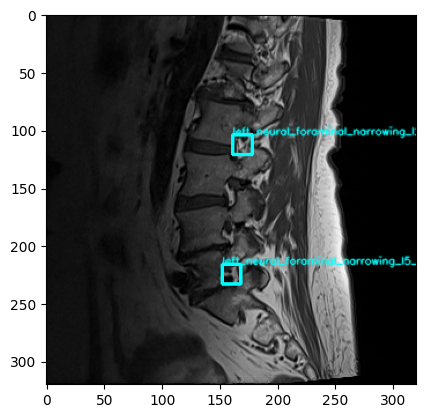

In [31]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name+'.jpg')

im = plt.imread(path).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    print(label)
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [32]:
# Initialize YOLO Model
model = YOLO(glob.glob("lsdc_yolov8/*/weights/best.pt")[0])

# Add W&B callback for Ultralytics
# add_wandb_callback(model, enable_model_checkpointing=True)

# Perform prediction which automatically logs to a W&B Table
# with interactive overlays for bounding boxes, segmentation masks
out = model.predict([path], save=True, conf=0.2)

# Finish the W&B run
wandb.finish()


0: 384x384 1 left_neural_foraminal_narrowing_l2_l3_normal/mild, 1 left_neural_foraminal_narrowing_l4_l5_normal/mild, 1 left_neural_foraminal_narrowing_l5_s1_normal/mild, 10.9ms
Speed: 2.5ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 384)
Results saved to runs/detect/predict


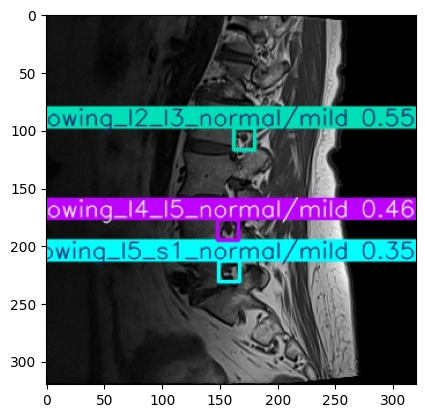

In [33]:
im = plt.imread(glob.glob(f'{out[0].save_dir}/*.jpg')[0])
plt.imshow(im)